In [2]:
import pandas as pd
import numpy as np
import requests
import json
import pickle
from collections import Counter
import matplotlib.pyplot as plt
from s2_key import *
from sklearn.decomposition import PCA

In [3]:
dem_df = pd.read_csv('annotated-excerpts-with-themes.csv')
dem_df = dem_df.loc[dem_df['1 = Relevant / 0 = Irrelevant'] == 1]
dem_df = dem_df.loc[dem_df['1 = Reference'] != 1]
dem_df = dem_df.loc[(dem_df['AS Explicit Theme'] == 'democratizing') | (dem_df['VG Explicit Theme'] == 'democratizing')]

In [8]:
dem_papers = set(dem_df['Corpus ID'])

In [8]:
emb = {}

for idx, corpusId in enumerate(dem_papers):
    if idx % 20 == 0:
        print(idx)

    data = requests.get(
        'https://api.semanticscholar.org/graph/v1/paper/CorpusID:{}?fields=embedding.specter_v2'.format(corpusId),
        headers = {"Accept": "*/*", "x-api-key": S2_KEY}
    ).json()
    
    if data is not None and 'embedding' in data:
        if data['embedding'] is not None and 'vector' in data['embedding']:
            emb[corpusId] = np.array(data['embedding']['vector'])
        else:
            print(data['embedding'])
    else:
        print(data)

0
20
40
60
80
100
120
{'error': 'Paper with id CorpusID:219303693 not found'}
140
None
160
180
200


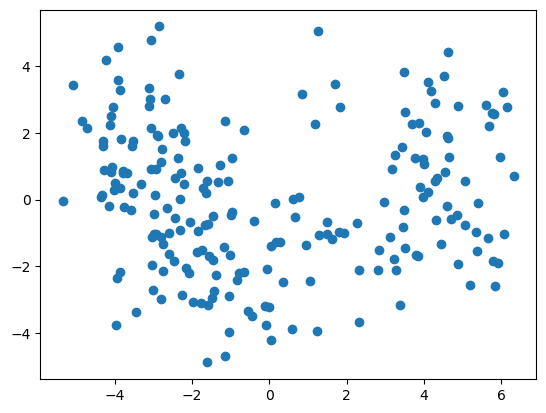

In [18]:
X = np.array([emb[i] for i in emb])
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)
plt.scatter(X_pca[:, 0], X_pca[:, 1])
plt.show()

In [4]:
excerpts = dem_df['Excerpt'].tolist()

In [18]:
API_URL = "https://api-inference.huggingface.co/models/sentence-transformers/all-MiniLM-L6-v2"
headers = {"Authorization": f"Bearer {HF_KEY}"}

import time

def query(payload):
    response = requests.post(API_URL, headers=headers, json=payload)
    return response.json()

sims = []
for idx, excerpt in enumerate(excerpts):
    if idx % 100 == 0:
        print(idx)
      
    data = query(
            {
                "inputs": {
                    "source_sentence": excerpt,
                    "sentences": excerpts
                }
            })
    while len(data) < len(excerpts):
        data = query(
            {
                "inputs": {
                    "source_sentence": excerpt,
                    "sentences": excerpts
                }
            })
        time.sleep(1)


    sims.append(data)

0
100
200


In [22]:
excerpt_sims = np.array(sims)
np.save('dem_excerpt_sims.npy', excerpt_sims)

In [37]:
import requests

API_URL = "https://api-inference.huggingface.co/pipeline/feature-extraction/sentence-transformers/all-mpnet-base-v2"
headers = {"Authorization": f"Bearer {HF_KEY}"}

def query(payload):
    response = requests.post(API_URL, headers=headers, json=payload)
    return response.json()

output = query({
    "inputs": excerpts
})

In [45]:
excerpt_emb = np.array(output)
np.save('dem_excerpt_emb.npy', excerpt_emb)

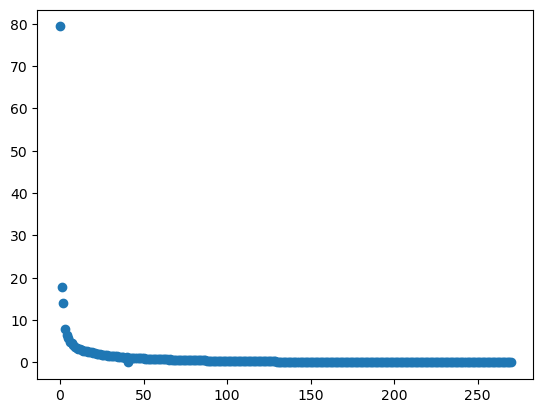

https://api.semanticscholar.org/CorpusID:218974468
https://api.semanticscholar.org/CorpusID:226299699
https://api.semanticscholar.org/CorpusID:218974352
https://api.semanticscholar.org/CorpusID:248780491
https://api.semanticscholar.org/CorpusID:246430787

https://api.semanticscholar.org/CorpusID:259376582
https://api.semanticscholar.org/CorpusID:235631955
https://api.semanticscholar.org/CorpusID:239998071
https://api.semanticscholar.org/CorpusID:259370846
https://api.semanticscholar.org/CorpusID:257378481

https://api.semanticscholar.org/CorpusID:259370569
https://api.semanticscholar.org/CorpusID:247447641
https://api.semanticscholar.org/CorpusID:248177810
https://api.semanticscholar.org/CorpusID:218973737
https://api.semanticscholar.org/CorpusID:246210292



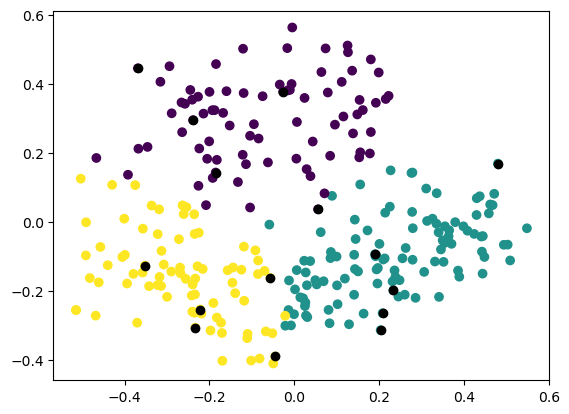

In [65]:
from sklearn.metrics.pairwise import cosine_similarity
excerpt_sims = cosine_similarity(excerpt_emb, excerpt_emb)

S = np.linalg.eig(excerpt_sims)[0]
plt.scatter(range(len(S)), S)
plt.show()

from sklearn.cluster import SpectralClustering
clustering = SpectralClustering(n_clusters=3, affinity='precomputed', assign_labels='discretize', random_state=0).fit(excerpt_sims)
# for v in np.unique(clustering.labels_):
#     print(np.array(excerpts)[clustering.labels_ == v][:5])
sampled_ids = []
for v in np.unique(clustering.labels_):
    for cid in np.random.permutation(np.unique(np.array(dem_df['Corpus ID'])[clustering.labels_ == v]))[:5]:
        sampled_ids.append((np.array(dem_df['Corpus ID']) == cid).nonzero()[0][0])
        print(f"https://api.semanticscholar.org/CorpusID:{cid}")
    print()
sampled_ids = np.array(sampled_ids)
    
pca = PCA(n_components=2)
X_pca = pca.fit_transform(excerpt_emb)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=clustering.labels_)
plt.scatter(X_pca[sampled_ids, 0], X_pca[sampled_ids, 1], c='k')
plt.show()